In [1]:
import torch
import io
import os
from math import log
import torch
from torch import tensor
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],-log(max(result['C_D'],1e-3))]



In [2]:

train_Y=tensor([[ 2.5682, -0.1000],
        [ 2.0647, -0.2619],
        [ 0.8586, -0.3635],
        [-0.1484, -0.5712],
        [ 0.1847, -0.2351],
        [ 2.6430, -0.0745],
        [ 2.0525, -0.1163],
        [ 0.6526, -0.3782],
        [ 0.2102, -0.7816],
        [-0.3878, -0.7461],
        [ 1.5345, -0.2404],
        [ 1.9892, -0.1187],
        [-0.3236, -0.1533],
        [ 0.4294, -0.3404],
        [ 0.4834, -0.2573],
        [ 2.3373, -0.0715],
        [ 0.6749, -0.2269],
        [-0.9758, -0.3770],
        [ 0.5953, -0.1955],
        [ 1.0729, -0.1619],
        [ 1.9164, -0.1899],
        [ 2.5516, -0.0683],
        [-0.2328, -0.3449],
        [ 2.0594, -0.0828],
        [ 0.8026, -0.2346],
        [ 1.9782, -0.2079],
        [ 1.7411, -0.2242],
        [-0.6203, -0.4925],
        [-0.0880, -0.4709],
        [ 1.0294, -0.5481],
        [-0.8890, -0.1470],
        [ 1.4512, -0.3181],
        [ 0.4131, -0.6159],
        [-0.1686, -0.5047],
        [ 0.6094, -0.1095],
        [ 2.4007, -0.2412],
        [ 0.8611, -0.3514],
        [ 1.0458, -0.3757],
        [ 1.5283, -0.2352],
        [ 0.8043, -0.6279],
        [ 2.5720, -0.0803],
        [ 2.5579, -0.1087],
        [ 2.7006, -0.0298],
        [ 2.7038, -0.0175],
        [ 2.5011, -0.0595],
        [ 2.5347, -0.1359],
        [ 2.6557, -0.0455],
        [ 2.6776, -0.0620],
        [ 2.4428, -0.0861],
        [ 2.7103, -0.0326]], dtype=torch.float64)
train_Y_log=tensor([[ 0.1674,  0.2564],
        [ 0.7936,  1.4822],
        [ 0.3221,  0.2812],
        [ 1.9782,  1.5708],
        [ 2.5682,  2.3028],
        [-0.0068, -0.0076],
        [ 2.5632,  2.7421],
        [ 1.8880,  1.8210],
        [ 1.1445,  2.1617],
        [ 0.2357,  1.5106],
        [-0.1413,  1.6523],
        [ 0.1847,  1.4477],
        [-0.4437,  0.2331],
        [-0.0587,  1.3783],
        [ 2.3373,  2.6377],
        [-0.6203,  0.7083],
        [-0.9963,  0.9493],
        [ 1.9164,  1.6613],
        [ 0.9866,  2.1796],
        [ 1.0294,  0.6014],
        [ 1.9108,  1.8137],
        [ 2.1724,  1.9516],
        [ 0.4294,  1.0776],
        [ 1.6101,  1.3918],
        [ 0.6749,  1.4832],
        [ 0.0243,  0.3156],
        [ 0.5701,  0.3651],
        [ 0.0447,  0.1697],
        [ 2.4744,  2.7713],
        [ 2.3167,  2.9390],
        [ 0.6315,  0.6008],
        [ 1.0458,  0.9788],
        [ 1.0729,  1.8208],
        [ 2.5529,  3.1740],
        [-0.3141,  0.9254],
        [ 0.6094,  2.2121],
        [-0.9758,  0.9755],
        [ 1.4512,  1.1454],
        [ 1.4377,  1.6688],
        [ 1.8186,  1.2679],
        [ 1.9892,  2.1312],
        [ 1.7804,  1.8980],
        [ 0.5953,  1.6324],
        [-0.0823, -0.0697],
        [ 1.8232,  1.5105],
        [ 1.9870,  1.6254],
        [ 0.2102,  0.2464],
        [ 0.7149,  0.5244],
        [ 2.0117,  1.5005],
        [-0.1437,  0.0167],
        [ 2.4642,  2.8047],
        [ 2.4348,  1.9983],
        [ 2.5593,  2.9972],
        [ 2.6102,  2.5698],
        [ 2.4577,  2.1441],
        [ 2.5135,  2.4941],
        [ 2.4884,  3.5005],
        [ 2.5272,  2.1940],
        [ 2.7007,  3.0705],
        [ 2.5183,  3.6546],
        [2.66843, 4.141624866803403],
        [2.67203, 3.762569052259808],
        [2.7295, 3.9538455002819846]], dtype=torch.float64)

train_Y_mono=tensor([[ 1.9108e+00, -1.6304e-01],
        [ 1.8017e+00, -2.6843e-01],
        [ 4.2945e-01, -3.4042e-01],
        [ 4.4654e-02, -8.4389e-01],
        [-9.7576e-01, -3.7701e-01],
        [-5.8702e-02, -2.5200e-01],
        [ 7.7013e-01, -1.1581e-01],
        [ 1.6741e-01, -7.7385e-01],
        [ 1.3113e+00, -1.6212e-01],
        [ 7.7724e-01, -2.7060e-01],
        [-6.2029e-01, -4.9247e-01],
        [-5.8960e-02, -8.8871e-02],
        [ 2.4007e+00, -2.4124e-01],
        [ 2.1674e+00, -8.4050e-02],
        [-4.4367e-01, -7.9206e-01],
        [ 4.8342e-01, -2.5727e-01],
        [ 1.9719e+00, -1.5712e-01],
        [ 2.5570e+00, -5.4346e-02],
        [ 1.5345e+00, -2.4041e-01],
        [ 1.1445e+00, -1.1513e-01],
        [-6.7834e-03, -1.0076e+00],
        [ 2.0117e+00, -2.2303e-01],
        [-2.3282e-01, -3.4492e-01],
        [ 6.5260e-01, -3.7816e-01],
        [ 1.0294e+00, -5.4807e-01],
        [ 9.2709e-02, -7.7229e-01],
        [ 1.8186e+00, -2.8142e-01],
        [ 6.7494e-01, -2.2691e-01],
        [ 1.8232e+00, -2.2079e-01],
        [ 1.0729e+00, -1.6189e-01],
        [-1.4375e-01, -9.8345e-01],
        [ 1.4900e+00, -2.0259e-01],
        [ 6.3148e-01, -5.4840e-01],
        [ 9.8665e-01, -1.1309e-01],
        [-3.1414e-01, -3.9636e-01],
        [ 1.8880e+00, -1.6187e-01],
        [ 8.2021e-01, -5.6311e-01],
        [-8.7996e-02, -4.7094e-01],
        [ 2.0525e+00, -1.1626e-01],
        [ 2.9027e-02, -1.0063e+00],
        [ 5.7279e-04, -4.8373e-01],
        [ 8.5858e-01, -3.6348e-01],
        [ 8.8596e-01, -5.0803e-01],
        [ 2.3167e+00, -5.2919e-02],
        [ 1.1430e+00, -1.3603e-01],
        [ 1.9870e+00, -1.9683e-01],
        [ 2.0299e+00, -1.9048e-01],
        [-1.7561e-01, -1.9722e-01],
        [-1.9726e-01, -7.4403e-01],
        [-9.9625e-01, -3.8700e-01],
        [ 8.0257e-01, -2.3464e-01],
        [-3.8775e-01, -7.4605e-01],
        [ 5.7011e-01, -6.9410e-01],
        [-4.8496e-01, -1.1085e+00],
        [ 1.3973e+00, -1.8386e-01],
        [-1.6858e-01, -5.0467e-01],
        [ 2.0647e+00, -2.6192e-01],
        [ 7.1490e-01, -5.9190e-01],
        [ 2.3099e+00, -1.6557e-01],
        [ 2.4343e-02, -7.2939e-01],
        [-3.2355e-01, -1.5335e-01],
        [-8.2309e-02, -1.0722e+00],
        [-2.0265e-01, -9.6671e-01],
        [ 1.6101e+00, -2.4862e-01],
        [ 2.1724e+00, -1.4205e-01],
        [ 1.4377e+00, -1.8848e-01],
        [ 2.0594e+00, -8.2818e-02],
        [ 5.9526e-01, -1.9546e-01],
        [ 1.5283e+00, -2.3519e-01],
        [ 1.6958e+00, -1.9776e-01],
        [ 2.0907e+00, -1.2127e-01],
        [ 1.7804e+00, -1.4987e-01],
        [ 4.1313e-01, -6.1589e-01],
        [ 4.0641e-01, -8.1466e-01],
        [ 1.6573e-01, -3.5981e-01],
        [ 2.3373e+00, -7.1525e-02],
        [ 2.4744e+00, -6.2582e-02],
        [ 1.7411e+00, -2.2421e-01],
        [ 2.1959e+00, -1.5570e-01],
        [ 1.4512e+00, -3.1809e-01],
        [ 1.0756e+00, -4.2521e-01],
        [ 6.2453e-01, -6.5732e-01],
        [ 1.9426e+00, -1.7194e-01],
        [ 2.1201e+00, -1.0107e-01],
        [-1.4131e-01, -1.9162e-01],
        [ 1.9091e+00, -1.9436e-01],
        [ 1.9164e+00, -1.8989e-01],
        [ 7.9361e-01, -2.2713e-01],
        [ 1.3560e-01, -6.3405e-01],
        [ 2.5516e+00, -6.8336e-02],
        [ 1.0458e+00, -3.7575e-01],
        [-4.9311e-01, -2.1676e-01],
        [-8.8901e-01, -1.4697e-01],
        [ 1.8465e-01, -2.3511e-01],
        [ 2.5682e+00, -9.9978e-02],
        [ 2.6430e+00, -7.4494e-02],
        [ 2.3574e-01, -2.2078e-01],
        [-5.6710e-01, -6.1196e-01],
        [ 1.8786e+00, -1.2848e-01],
        [ 2.3807e+00, -1.2993e-01],
        [ 2.4691e+00, -1.1511e-01],
        [ 2.6446e+00, -4.0922e-02],
        [ 2.3970e+00, -1.2033e-01],
        [ 2.6023e+00, -6.1409e-02],
        [ 2.6317e+00, -5.8296e-02],
        [ 2.5189e+00, -4.5082e-02],
        [ 2.5423e+00, -7.2888e-02],
        [ 2.5436e+00, -3.6328e-02],
        [ 2.5389e+00, -3.0071e-02],
        [ 2.5902e+00, -6.7474e-02],
        [ 6.6566e-01, -1.5743e-01],
        [ 2.5429e+00, -6.7588e-02],
        [ 2.5650e+00, -8.2163e-02],
        [ 2.7132e+00, -3.1026e-02],
        [ 2.4508e+00, -5.6917e-02],
        [ 2.4514e+00, -1.2071e-01],
        [ 2.5212e+00, -1.4256e-01],
        [ 2.4291e+00, -1.1102e-01],
        [ 2.7361e+00, -1.9102e-02],
        [ 2.5785e+00, -4.8457e-02],
        [ 2.7407e+00, -1.5117e-02],
        [ 2.7404e+00, -1.5373e-02],
        [ 2.7413e+00, -1.5626e-02],
        [ 2.7001e+00, -2.2282e-02],
        [ 1.9870e+00, -1.9683e-01],
        [ 2.5603e+00, -4.8147e-02],
        [ 2.5131e+00, -4.9930e-02],
        [ 2.5186e+00, -5.0879e-02]], dtype=torch.float64)

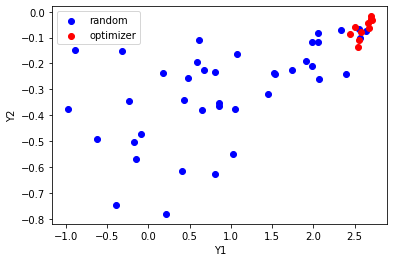

In [3]:
import plotting
plotting.plot_population(train_Y,10)

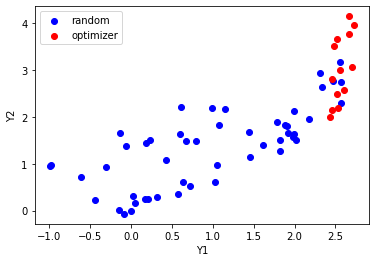

In [4]:

plotting.plot_population(train_Y_log,13)

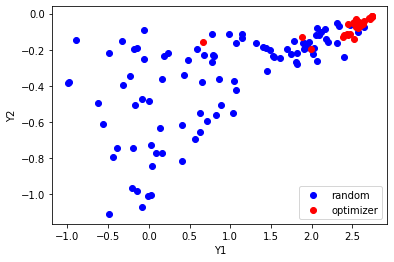

In [5]:

plotting.plot_population(train_Y_mono,30)